**Обновление библиотек**

In [ ]:
!pip install -U torch torchvision

**Импорт необходимых библиотек**

In [ ]:
import torch
import torchvision
import PIL
import numpy as np

import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms,models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

#Импортируем scheduler, который будет изменять наш learning rate
from torch.optim import lr_scheduler

import random
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import drive

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Проверим доступность видеокарты

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Подключим наше виртуальное хранилище от Google

In [ ]:
drive.mount('/content/gdrive/')
!ls gdrive/MyDrive/Simpsons/dataset/train

Mounted at /content/gdrive/
simpsons_dataset


In [ ]:
!ls gdrive/MyDrive/Simpsons/dataset/train

abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


Создадим функцию, которая позволит сделать наши результаты воспроизводимыми:

In [ ]:
def set_seed(seed=42):
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы используем враппер над датасетом для удобной работы.  
ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet.

Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следует привести их к одному размеру (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        #Аугментируем данные для обучения, стандартизируем размер картинок, преобразовываем изображения 
        #в тензоры PyTorch и нормализуем входы
        #Аугментация осуществляется только на train выборке
        transform = {'train':transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),                                   
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.RandomHorizontalFlip(),                                      
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ]),
            'test':transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        }
        transform=transform['train' if self.mode=='train' else 'test']
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

Функция для отображения картинок

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Формируем данные для обучения, валидации и тестовые данные:

In [ ]:
TRAIN_DIR = Path('gdrive/MyDrive/Simpsons/dataset/train')
TEST_DIR = Path('gdrive/MyDrive/Simpsons/dataset/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

Посмотрим на наших героев внутри датасета

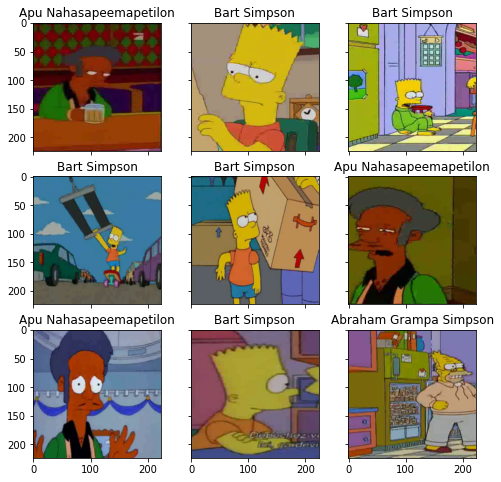

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Отбалансируем данные, откопируем картинки малочисленных классов менее 100 картинок из выборки train, так чтобы число на каждый малочисленный класс было не менее 100.

In [ ]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

#Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями - списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

#Дополним классы, у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

train_dataset = SimpsonsDataset(new_train_files, mode='train')

Функции обучения и предсказания на обучающей и валидационной составляющей:

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer,scheduler):
    #Применяем функцию для воспроизводимости данных
    set_seed()
    
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    scheduler.step()              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        # Умножаем learning_rate на 0.1 каждые 7 эпох
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)


        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt,exp_lr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Используем сеть resnet, предобученную на ImageNet

In [ ]:
#Очищаем кэш видеокарты
torch.cuda.empty_cache()

resnet = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Посмотрим, из каких слоев состоит сеть

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Используем Fine Tuning и заморозим первый слой, отвечающий за извлечение признаков, а обучать будем оставшиеся 3 слоя из Feature Extractor и классификационную часть (полносвязную сеть)

In [ ]:
for param in resnet.conv1.parameters():
    param.requires_grad = False

for param in resnet.bn1.parameters():
    param.requires_grad = False

for param in resnet.layer1.parameters():
    param.requires_grad = False

# Заменяем последний слой классификатора на слой с 42 выходами (поскольку 42 класса для предсказания)
resnet.fc = nn.Linear(2048, 42)

Посмотрим, параметры каких слоёв нейросети будут обучаться и переведем нашу модель на видеокарту:

In [ ]:
print("Params to learn:")

params_to_update = []
for name,param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

resnet = resnet.cuda()

Params to learn:
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.1.conv3.weight
	 layer2.1.bn3.weight
	 layer2.1.bn3.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.2.conv3.weight
	 layer2.2.bn3.weight
	 layer2.2.bn3.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1.bias
	 layer2.3.conv2.weight
	 layer2.3.bn2.weight
	 layer2.3.bn2.bias
	 layer2.3.conv3.weight
	 layer2.3.bn3.weight
	 layer2.3.bn3.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0

Обучим нашу сеть:

In [ ]:
#Указано малое количество эпох для ускорения, для получения объективной оценки необходимо увеличивать этот показатель
history = train(train_dataset, val_dataset, model=resnet, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.9818779311048875


epoch:  50%|█████     | 1/2 [1:34:08<1:34:08, 5648.66s/it]


Epoch 001 train_loss: 0.9819     val_loss 0.6372 train_acc 0.7500 val_acc 0.8349
loss 3.320923734790794


epoch: 100%|██████████| 2/2 [1:40:11<00:00, 3005.62s/it]


Epoch 002 train_loss: 3.3209     val_loss 3.1817 train_acc 0.0983 val_acc 0.1074


Построим кривые обучения

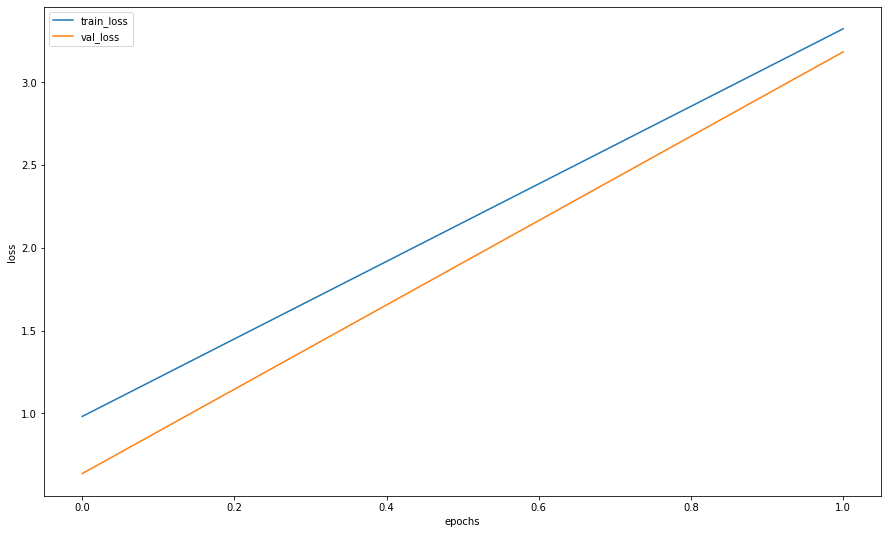

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Теперь обучим сеть на всем train датасете

In [ ]:
def train_without_val(train_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    vtrain_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        # Умножаем learning_rate на 0.1 каждые 7 эпох
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)


        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt,exp_lr_scheduler)
            print("loss", train_loss)
            
            history.append((train_loss, train_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           t_acc=train_acc))
            
    return history

In [ ]:
#Очищаем кэш видеокарты
torch.cuda.empty_cache()

resnet = models.resnet50(pretrained = True)

for param in resnet.conv1.parameters():
    param.requires_grad = False

for param in resnet.bn1.parameters():
    param.requires_grad = False

for param in resnet.layer1.parameters():
    param.requires_grad = False

resnet.fc = nn.Linear(2048, 42)

resnet = resnet.cuda()

In [ ]:
history = train_without_val(train_dataset, model=resnet, epochs=13, batch_size=64)

epoch:   8%|▊         | 1/13 [05:28<1:05:38, 328.22s/it]

loss 0.9767881201829879

Epoch 001 train_loss: 0.9768     vtrain_acc 0.7532


epoch:  15%|█▌        | 2/13 [10:54<1:00:00, 327.28s/it]

loss 0.36301655850535

Epoch 002 train_loss: 0.3630     vtrain_acc 0.9029


epoch:  23%|██▎       | 3/13 [16:21<54:28, 326.86s/it]

loss 0.20769080125075468

Epoch 003 train_loss: 0.2077     vtrain_acc 0.9420


epoch:  31%|███       | 4/13 [21:47<48:57, 326.44s/it]

loss 0.15001602293397062

Epoch 004 train_loss: 0.1500     vtrain_acc 0.9584


epoch:  38%|███▊      | 5/13 [27:15<43:36, 327.04s/it]

loss 0.11917078630906673

Epoch 005 train_loss: 0.1192     vtrain_acc 0.9655


epoch:  46%|████▌     | 6/13 [32:43<38:11, 327.36s/it]

loss 0.10027146547692094

Epoch 006 train_loss: 0.1003     vtrain_acc 0.9709


epoch:  54%|█████▍    | 7/13 [38:14<32:52, 328.77s/it]

loss 0.07334946009663126

Epoch 007 train_loss: 0.0733     vtrain_acc 0.9790


epoch:  62%|██████▏   | 8/13 [43:43<27:23, 328.61s/it]

loss 0.027816367686772182

Epoch 008 train_loss: 0.0278     vtrain_acc 0.9920


epoch:  69%|██████▉   | 9/13 [49:09<21:51, 327.94s/it]

loss 0.005065879640891568

Epoch 009 train_loss: 0.0051     vtrain_acc 0.9995


epoch:  77%|███████▋  | 10/13 [54:34<16:21, 327.16s/it]

loss 0.0027888535547005984

Epoch 010 train_loss: 0.0028     vtrain_acc 0.9997


epoch:  85%|████████▍ | 11/13 [59:59<10:52, 326.41s/it]

loss 0.0018662703329640473

Epoch 011 train_loss: 0.0019     vtrain_acc 0.9999


epoch:  92%|█████████▏| 12/13 [1:05:24<05:25, 325.97s/it]

loss 0.001338872542571316

Epoch 012 train_loss: 0.0013     vtrain_acc 0.9999


epoch: 100%|██████████| 13/13 [1:10:49<00:00, 326.91s/it]

loss 0.0010156272189700895

Epoch 013 train_loss: 0.0010     vtrain_acc 1.0000


Наконец, сделаем предсказания на тестовой выборке и сохраним результат в csv файл

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/Simpsons/simpsons_resnet_1_freeze_2022.csv', index=False)  

Score на Kaggle: 0.99256  
https://www.kaggle.com/competitions/journey-springfield/leaderboard